# Training a CNN for DPU compilation
----

## Aim/s

In this notebook we show how to train a simple Convolutional Neural Network (CNN)
on the MNIST handwritten digit dataset for deployment on the DPU. We will cover:

* Loading and pre-processing the imagenet dataset
* Training a CNN with Tensorflow2
* Quantizing and evaluating the quantized model
* Compiling for DPU using the Vitis AI compiler

## References

* [Vitis AI model zoo](https://github.com/Xilinx/Vitis-AI/tree/master/models/AI-Model-Zoo)

## Last revised
* Dec 13, 2021
    * Initial revision
----

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.3.0


## 1. Load dataset

The MNIST dataset comes with 60k training and 10k test examples that are
28x28 grayscale images, along with their labels which are just the 
corresponding digits saved as integers. We can use the `keras.datasets`
utility to load the MNIST dataset straight into our Jupyter environment.

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

print('Training data: {}, {}'.format(x_train.shape, y_train.shape))
print('Test data: {}, {}'.format(x_test.shape, y_test.shape))

Training data: (60000, 28, 28), (60000,)
Test data: (10000, 28, 28), (10000,)


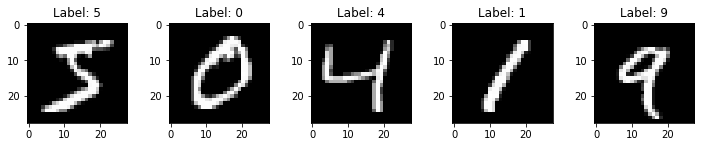

In [3]:
fig, axs = plt.subplots(1, 5, figsize=(10, 10))
plt.tight_layout()

for i in range(5):
    axs[i].imshow(x_train[i], 'gray')
    axs[i].set_title('Label: {}'.format(y_train[i]))

Next we will normalize the training and test images. We also need to add
color channel. All these pre-processing steps are required by Conv2D layers.

In [4]:
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = np.expand_dims(x_train, axis=3)
x_test = np.expand_dims(x_test, axis=3)

## 2. Train the model

Create a `tensorflow.keras.model` object by passing a list of layers. Because the MNIST dataset is not difficult, we can use a very simple network with a single convolutional layer.

In [5]:
inputs = tf.keras.Input(shape=(28,28,1))
x = tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1))(inputs)
x = tf.keras.layers.MaxPooling2D((2,2))(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs, name='mnist_classifier')
model.summary()

Model: "mnist_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 5408)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               692352    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 693,962
Trainable params: 693,962
Non-trainable params: 0
____________________________________________

Configure the model for training: choose desired optimizer, loss function
and metrics to observe over the training period.

In [6]:
model.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy", 
              metrics=['accuracy'])

Now we can train the model.

In [7]:
history = model.fit(x_train, y_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 15s 8ms/step - loss: 0.1437 - accuracy: 0.9572
Epoch 2/5
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0492 - accuracy: 0.9855
Epoch 3/5
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0316 - accuracy: 0.9899
Epoch 4/5
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0202 - accuracy: 0.9931
Epoch 5/5
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0150 - accuracy: 0.9951


We can inspect the training results by plotting the collected data in the
`history` object.

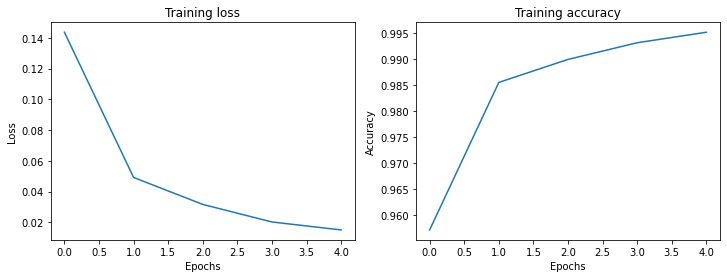

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(history.history['loss'])
axs[0].set_title('Training loss')
axs[0].set(xlabel='Epochs', ylabel='Loss')

axs[1].plot(history.history['accuracy'])
axs[1].set_title('Training accuracy')
axs[1].set(xlabel='Epochs', ylabel='Accuracy')
plt.show()

Evaluate the trained model on the test dataset.

In [9]:
loss, accuracy = model.evaluate(x_test,y_test)
print("Test loss: {}".format(loss))
print("Test accuracy: {}".format(accuracy))

313/313 [==============================] - 1s 2ms/step - loss: 0.0478 - accuracy: 0.9864
Test loss: 0.047750502824783325
Test accuracy: 0.9864000082015991


Currently the entire model graph is saved as a set of weights in floating point precision. We can make sure of that by printing out the dtype of one of the layers.

In [10]:
model.get_weights()[0].dtype

dtype('float32')

## 3. Quantization
In order to compile the trained model for deployment on a DPU platform, we must first quantize it. Here we will use the `vitis_quantize` module to convert the floating point model into an INT8 quantized representation. 

In [11]:
from tensorflow_model_optimization.quantization.keras import vitis_quantize

**Quantize model**

By default the `quantize_model` function converts the weights, activations and inputs into 8-bit wide numbers. We can specify different values and configurations using `weight_bit`, `activation_bit` and other parameters. 

In [12]:
quantizer = vitis_quantize.VitisQuantizer(model)
quantized_model = quantizer.quantize_model(calib_dataset = x_test[1:1024], weight_bit=8, activation_bit=8)

[VAI INFO] Update activation_bit: 8
[VAI INFO] Update weight_bit: 8
[VAI INFO] Start CrossLayerEqualization...
10/10 [==============================] - 0s 38ms/step
[VAI INFO] CrossLayerEqualization Done.
[VAI INFO] Start Quantize Calibration...
32/32 [==============================] - 0s 13ms/step
[VAI INFO] Quantize Calibration Done.
[VAI INFO] Start Post-Quantize Adjustment...
[VAI INFO] Post-Quantize Adjustment Done.
[VAI INFO] Quantization Finished.


**Evaluate quantized model**

In order to evaluate the quantized model, it needs to be re-compiled with the desired loss and evaluation metrics, such as accuracy. Since we are using 8-bit quantization we do not lose much performance, if at all.

In [13]:
quantized_model.compile(loss='sparse_categorical_crossentropy', metrics=["accuracy"])

score = quantized_model.evaluate(x_test, y_test,  verbose=0, batch_size=32)
print(score)

[0.047555871307849884, 0.98580002784729]


**Save quantized model**

Once we are happy with the performance of the quantized model, we can save it as a .h5 file, simply using the `save` method.

In [14]:
quantized_model.save('tf2_mnist_classifier_quantized.h5')

## 4. Compilation

For this final step we use the Vitis AI compiler `vai_c_tensorflow2` and pass the quantized model as a parameter. In this example we are compiling the DPU model targeting the KV260 board, however to target a different board you will just have to point the compiler to the right `arch.json` file. 

For example, for the ZCU104 you would pass

`--arch /opt/vitis_ai/compiler/arch/DPUCZDX8G/ZCU104/arch.json`

and for Ultra96, we can pass the custom arch.json in this repository

`--arch ./arch.json`

In [15]:
!vai_c_tensorflow2 \
    --model ./tf2_mnist_classifier_quantized.h5 \
    --arch /opt/vitis_ai/compiler/arch/DPUCZDX8G/KV260/arch.json \
    --output_dir . \
    --net_name mnist_classifier

**************************************************
* VITIS_AI Compilation - Xilinx Inc.
**************************************************
[INFO] Namespace(batchsize=1, inputs_shape=None, layout='NHWC', model_files=['./tf2_mnist_classifier_quantized.h5'], model_type='tensorflow2', named_inputs_shape=None, out_filename='/tmp/mnist_classifier_org.xmodel', proto=None)
[INFO] tensorflow2 model: /workspace/tf2_mnist_classifier_quantized.h5
[INFO] keras version: 2.4.0
[INFO] Tensorflow Keras model type: functional
[INFO] generate xmodel     :100%|█| 18/18 [00:00<00:00, 466.45it/s]             
[INFO] dump xmodel: /tmp/mnist_classifier_org.xmodel
[UNILOG][INFO] Target architecture: DPUCZDX8G_ISA0_B4096_MAX_BG2
[UNILOG][INFO] Compile mode: dpu
[UNILOG][INFO] Debug mode: function
[UNILOG][INFO] Target architecture: DPUCZDX8G_ISA0_B4096_MAX_BG2
[UNILOG][INFO] Graph name: mnist_classifier, with op num: 26
[UNILOG][INFO] Begin to compile...
[UNILOG][INFO] Total device subgraph number 3, DPU subgra

----

Copyright (C) 2021 Xilinx, Inc

SPDX-License-Identifier: Apache-2.0 License

----

----